

---
### This is a sample Colab notebook for quick experimentation for the PuTC Global Data Science Hackathon 2023-24.
---



### Install dependencies and required libraries

---



In [1]:
!pip install scikit-learn
!pip install scipy
!pip install pandas
!pip install pymatreader
!pip install imblearn
!pip install ipdb
#!pip install torch==1.13.0+cu116 torchvision==0.14.0+cu116 torchaudio==0.13.0 --extra-index-url https://download.pytorch.org/whl/cu116

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.4 MB/s eta 0:00:00


### Import libraries

---



In [2]:
import os
import random
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import math
import pandas as pd
from torch.nn import functional as F
import numpy as np
import scipy.io as sio
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from imblearn.over_sampling import RandomOverSampler
from numpy import linalg as LA
from pymatreader import read_mat
from sklearn import preprocessing
from numpy.linalg import norm
from sklearn.decomposition import PCA

### Prepare Colab and mount Google drive
The following code snippet is required only if you are using Google Colab. If you want to store the data files to your Google drive, you need to mount it to access the files.

---



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Helper functions

---



In [4]:
def map_label_hk(label, classes):
  mapped_label = np.empty((label.shape[0], ), np.int8)
  for i in range(classes.shape[0]):
    mapped_label[label==classes[i]] = i
  return mapped_label

def map_label(label, classes):
  mapped_label = torch.LongTensor(label.size())
  for i in range(classes.shape[0]):
    mapped_label[label==classes[i], ] = i

  return mapped_label

#Initialie the model weights with normal distribution
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Linear') != -1:
    m.weight.data.normal_(0.0, 0.02)
    m.bias.data.fill_(0)
  elif classname.find('BatchNorm') != -1:
    m.weight.data.normal_(1.0, 0.02)
    m.bias.data.fill_(0)

#Sample the batch of random training samples
def sample():
  batch_feature, batch_att = data.next_batch(opt.batch_size)
  input_res.copy_(batch_feature)
  input_att.copy_(batch_att)

#Loss function for mean squared loss
def mse_custom_loss(latent_from_vis, latent_from_att):
	L2 = torch.sum((latent_from_vis - latent_from_att) ** 2)
	return L2

def evaluate_model_performance(net, ctr):
    # ipdb.set_trace()
    mapped_batch_label = map_label(data.val_label, data.val_classes)
    allattributes = data.allattribute.detach().cpu().numpy()
    val_att = allattributes[mapped_batch_label]
    val_att_normalized = val_att / np.linalg.norm(val_att, axis=1, keepdims=True)
    pred_att_val = net(data.val_feature.cuda(), torch.tensor(val_att_normalized).cuda()) #data.val_feature.cuda(),
    pred_att_val = pred_att_val.detach().cpu().numpy()
    val_label = data.val_label.detach().cpu().numpy()
    val_attributes = allattributes[len(data.train_classes):]

	  #validation
    pred_val_labels = [np.argmax([np.dot(x, y) / (norm(x) * norm(y)) for y in val_attributes]) for x in pred_att_val]
    pred_val_labels = np.array(data.val_classes)[pred_val_labels]
    val_zsl_acc = balanced_accuracy_score(val_label, pred_val_labels)
    return val_zsl_acc


### Define your neural network
We will use a simple neural network of multilayer perceptron to build mapping function for ZSL. The NN takes in visual data as input and projects it onto semantic space.

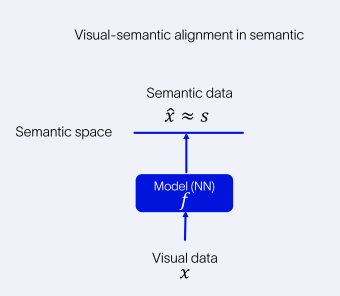

In [13]:
class ZeroShotModel(nn.Module):
    def __init__(self, opt):
        super(ZeroShotModel, self).__init__()

        self.image_fc = nn.Linear(opt.res_size, opt.hidden_dim)
        self.text_fc = nn.Linear(opt.att_size, opt.hidden_dim)

        self.attention = nn.MultiheadAttention(embed_dim=opt.hidden_dim, num_heads=8, batch_first=True)

        self.fc1 = nn.Linear(opt.hidden_dim * 2, opt.hidden_dim)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(opt.dropout_rate)

        self.fc2 = nn.Linear(opt.hidden_dim, opt.att_size)

    def forward(self, image_features, text_embeddings):
        # Project image features and side information embeddings
        image_features = self.image_fc(image_features)
        text_embeddings = self.text_fc(text_embeddings)

        # Apply attention mechanism
        attention_output_e2v, _ = self.attention(image_features.unsqueeze(1), text_embeddings.unsqueeze(1), text_embeddings.unsqueeze(1))
        attention_output_e2v = torch.mean(attention_output_e2v, dim = 1)

        attention_output_v2e, _ = self.attention(text_embeddings.unsqueeze(1), image_features.unsqueeze(1), image_features.unsqueeze(1))
        attention_output_v2e = torch.mean(attention_output_v2e, dim = 1)

        # Fuse the attention outputs
        fused_features =  torch.stack((attention_output_e2v, attention_output_v2e), dim = 1)
        fused_features_mean, fused_features_std = torch.std_mean(fused_features, dim = 1)
        fused_features = torch.cat((fused_features_mean, fused_features_std), dim = -1) #[batch_size, 2*hidden_dim]

        combined_features = fused_features

        # Fully connected layers
        x = self.fc1(combined_features)
        # x = self.relu1(x)
        # x = self.dropout1(x)

        x = self.fc2(x)

        return x

### Define experiment parameters

---



In [6]:
#class to hold experimental paramters
class PARAMS(object):
  def __init__(self):
      #Model weights are updated by processing self.batch_size number of training samples
      self.batch_size=32
      #Visual feature dimension
      self.res_size=2048
      #Semantic/textual feature dimension
      self.att_size=750
      #Total number of epochs
      self.nepoch=5
      #Learning rate for model training
      self.lr=0.0001
      #True of if GPU available else false
      self.cuda=True
      #Fix the experiment seed for reproducibility
      self.manual_seed=0
      #hidden dim
      self.hidden_dim = 512
      #dropout rate
      self.dropout_rate = 0.5

opt = PARAMS()
print(opt)


### Set up the seed for the experiment

---



In [7]:
random.seed(opt.manual_seed)
torch.manual_seed(opt.manual_seed)
if opt.cuda:
    torch.cuda.manual_seed_all(opt.manual_seed)

### Load hackathon dataset and prepare Data Loader
Data loader helps in efficeintly consuming training dataset during model training.

---



In [8]:
class DATA_LOADER_HK(object):
  def __init__(self, opt, ):
    #Load the training dataset. You need to copy it to Google drive. and place in the DS_Hackathon2023 directory.
    train_feature = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/hackathon/data/train/train_feature.csv').values
    train_label = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/hackathon/data/train/train_label.csv').values.flatten()
    train_attribute = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/hackathon/data/train/train_attribute.csv').values
    train_image_names = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/hackathon/data/train/train_image_names.csv').values

    train_classes = np.unique(train_label)

    #Create a validation data out of training data
    num_val_classes = int(0.4*len(train_classes))
    num_train_classes = len(train_classes) - num_val_classes

    self.train_classes = train_classes[:num_train_classes]
    self.val_classes = train_classes[num_train_classes:]
    self.nall_classes = len(self.train_classes) + len(self.val_classes)

    ros = RandomOverSampler()
    train_feature, train_label = ros.fit_resample(train_feature, train_label)

    self.allattribute = train_attribute

    #create new train validation split for labels and features
    new_train_loc = []
    for cl in self.train_classes:
      new_train_loc.append((np.nonzero(train_label == cl)[0]).tolist())

    new_train_loc = [item for sublist in new_train_loc for item in sublist]

    new_val_loc = []
    for cl in self.val_classes:
      new_val_loc.append((np.nonzero(train_label == cl)[0]).tolist())

    new_val_loc = [item for sublist in new_val_loc for item in sublist]

    self.train_label = train_label[new_train_loc]
    self.train_feature = train_feature[new_train_loc]
    self.val_label = train_label[new_val_loc]
    self.val_feature = train_feature[new_val_loc]

    print('Train classes', len(self.train_classes), self.train_classes)
    print('Val classes', len(self.val_classes), self.val_classes)

    print('Number of train samples', len(self.train_label))
    print('Number of Val samples', len(self.val_label))
    print('attribute size ', self.allattribute.shape)

    scaler = preprocessing.StandardScaler()

    _train_feature = scaler.fit_transform(self.train_feature)
    _val_feature = scaler.transform(self.val_feature)

    # pca = PCA(n_components=248)
    # _train_feature = pca.fit_transform(_train_feature)
    # _val_feature = pca.fit_transform(_val_feature)

    self.train_feature = torch.from_numpy(_train_feature).float()
    self.train_label = torch.from_numpy(self.train_label).long()
    self.val_label = torch.from_numpy(self.val_label).long()
    self.val_feature = torch.from_numpy(_val_feature).float()
    self.allattribute = torch.from_numpy(self.allattribute).float()
    self.ntrain = self.train_feature.size()[0]

  def next_batch(self, batch_size):
    idx = torch.randperm(self.ntrain)[0:batch_size]
    batch_feature = self.train_feature[idx]
    batch_label = self.train_label[idx]
    mapped_batch_label = map_label(batch_label, data.train_classes)
    batch_att = self.allattribute[mapped_batch_label]
    return batch_feature, batch_att

In [9]:
#cudnn.benchmark = True
if torch.cuda.is_available() and not opt.cuda:
	print("WARNING: You have a CUDA device, so you should probably run with --cuda")

# load data
data = DATA_LOADER_HK(opt)

Train classes 17 [ 0  1  2  3  5  6  7 10 12 14 17 19 22 23 24 25 30]
Val classes 10 [31 33 35 36 37 39 40 43 45 49]
Number of train samples 21709
Number of Val samples 12770
attribute size  (27, 750)


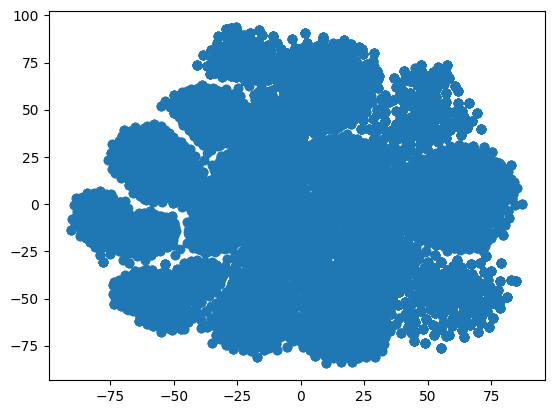

In [ ]:
# from sklearn.manifold import TSNE
# tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca', random_state=42)
# features_embedded = tsne.fit_transform(data.train_feature)  # features is your original high-dimensional data

# import matplotlib.pyplot as plt
# plt.scatter(features_embedded[:, 0], features_embedded[:, 1])
# plt.show()


In [14]:
#Create an instance of your model
net_model = ZeroShotModel(opt)
#Define the torch tensors for input and output
input_res = torch.FloatTensor(opt.batch_size, opt.res_size)
input_att = torch.FloatTensor(opt.batch_size, opt.att_size)

#Transfer your data and model to GPU if available
if opt.cuda:
  net_model.cuda()
  input_res = input_res.cuda()
  input_att = input_att.cuda()

### Prepare for model training

---



In [15]:
# setup optimizer
optimizerNet = optim.AdamW(net_model.parameters(), lr=opt.lr, betas=(0.5, 0.999), weight_decay=0.0001) #, betas=(0.5, 0.999), weight_decay=0.0001
#set up model in training mode
net_model.train()

ZeroShotModel(
  (image_fc): Linear(in_features=2048, out_features=512, bias=True)
  (text_fc): Linear(in_features=750, out_features=512, bias=True)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
  )
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=750, bias=True)
)

### Train the model

---



In [16]:
ctr = 0
#Train the model by passing training data opt.nepoch times
for epoch in range(opt.nepoch):
	for i in range(0, data.ntrain, opt.batch_size):
		#sample the batch of training samples
		sample()
		#Make input/output tensors Variable to allow backpropogation of gradients
		input_resv = Variable(input_res)
		input_attv = Variable(input_att)
		input_attv = nn.functional.normalize(input_attv, dim=1)
		pred_sem = net_model(input_resv, input_attv)
		#calculate the loss
		latent_loss = mse_custom_loss(pred_sem, input_attv)
		total_loss = latent_loss
		#Reset the gradients
		net_model.zero_grad()
		#Backpropogate the loss
		total_loss.backward()
		#Update the model gradients
		optimizerNet.step()
		#Set up the model in evaluation mode i.e. no more weight updates by gradients
		net_model.eval()
		if (i % (opt.batch_size*10) ==0):
			ctr+=1
			val_zsl_acc = evaluate_model_performance(net_model, ctr)
			print('[%5d] Loss: %.4f |Acc: ZSL %.4f, %d ctr'%(epoch, total_loss, val_zsl_acc, ctr))
		#Set up the model back to training mode i.e. allows weight updates by gradients
		net_model.train()


[    0] Loss: 116.8260 |Acc: ZSL 0.0777, 1 ctr
[    0] Loss: 42.8472 |Acc: ZSL 0.0947, 2 ctr
[    0] Loss: 30.3851 |Acc: ZSL 0.1118, 3 ctr
[    0] Loss: 29.0917 |Acc: ZSL 0.1164, 4 ctr
[    0] Loss: 25.2491 |Acc: ZSL 0.1399, 5 ctr
[    0] Loss: 21.3337 |Acc: ZSL 0.2039, 6 ctr
[    0] Loss: 22.0845 |Acc: ZSL 0.2137, 7 ctr
[    0] Loss: 17.1469 |Acc: ZSL 0.2662, 8 ctr
[    0] Loss: 15.5678 |Acc: ZSL 0.2897, 9 ctr
[    0] Loss: 15.4516 |Acc: ZSL 0.2936, 10 ctr
[    0] Loss: 13.4544 |Acc: ZSL 0.3229, 11 ctr
[    0] Loss: 14.5933 |Acc: ZSL 0.3289, 12 ctr
[    0] Loss: 11.5756 |Acc: ZSL 0.3428, 13 ctr
[    0] Loss: 12.6159 |Acc: ZSL 0.3637, 14 ctr
[    0] Loss: 8.5402 |Acc: ZSL 0.3611, 15 ctr
[    0] Loss: 10.6149 |Acc: ZSL 0.3823, 16 ctr
[    0] Loss: 8.8930 |Acc: ZSL 0.3814, 17 ctr
[    0] Loss: 8.1691 |Acc: ZSL 0.4047, 18 ctr
[    0] Loss: 7.8877 |Acc: ZSL 0.3865, 19 ctr
[    0] Loss: 6.9092 |Acc: ZSL 0.3800, 20 ctr
[    0] Loss: 7.6305 |Acc: ZSL 0.3847, 21 ctr
[    0] Loss: 8.0130 |Acc: 

In [17]:
torch.save(net_model.state_dict(), f'/content/drive/MyDrive/Colab Notebooks/hackathon/model/best_model_light_1.pt')

In [18]:
class DATA_LOADER_HK_TEST(object):
  def __init__(self):
    #Load the training dataset. You need to copy it to Google drive. and place in the DS_Hackathon2023 directory.
    test_feature = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/hackathon/data/test/test_set1_feature.csv').values
    test_label = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/hackathon/data/test/test_set1_label.csv').values.flatten()
    test_attribute = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/hackathon/data/test/test_set1_attribute.csv').values
    test_image_names = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/hackathon/data/test/test_set1_image_names.csv').values

    test_classes = np.unique(test_label)
    self.test_classes = test_classes
    self.allattribute = test_attribute
    self.test_label = test_label
    self.test_feature = test_feature
    self.test_image_names = test_image_names

    print('Test classes', len(self.test_classes), self.test_classes)
    print('Number of test samples', len(self.test_label))
    print('attribute size ', self.allattribute.shape)

    scaler = preprocessing.StandardScaler()

    _test_feature = scaler.fit_transform(self.test_feature)

    # pca = PCA(n_components=248)
    # _test_feature = pca.fit_transform(_test_feature)

    self.test_feature = _test_feature
    self.test_label = self.test_label

    self.allattribute = self.allattribute
    self.ntrain = self.test_feature.shape[0]

    label_index = map_label(torch.tensor(self.test_label), torch.tensor(self.test_classes))
    self.attributes = self.allattribute[label_index]
    print("Test attribute index: ", self.attributes.shape)

In [19]:
test_data = DATA_LOADER_HK_TEST()
test_res = torch.from_numpy(test_data.test_feature).float()
test_att = torch.from_numpy(test_data.attributes).float()

Test classes 13 [ 4  8 11 15 18 21 26 27 32 41 44 46 48]
Number of test samples 8826
attribute size  (13, 750)
Test attribute index:  (8826, 750)


In [20]:
model_state_dict = torch.load('/content/drive/MyDrive/Colab Notebooks/hackathon/model/best_model_light_1.pt')
# net_model = MLP_NET_HK(opt)
net_model.load_state_dict(model_state_dict)
net_model.eval()
net_model.cuda()
with torch.no_grad():
    test_att_normalized = nn.functional.normalize(test_att, dim=1)
    pred_sem = net_model(test_res.cuda(), test_att_normalized.cuda())
    pred_sem = pred_sem.cpu().detach().numpy()

In [21]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

val_label = test_data.test_label
val_attributes = test_data.attributes

#validation
cosine_sim_matrix = cosine_similarity(pred_sem, val_attributes)
pred_val_labels = np.argmax(cosine_sim_matrix, axis=1)

pred_val_labels = np.array(val_label)[pred_val_labels]
val_zsl_acc = balanced_accuracy_score(val_label, pred_val_labels)
print(val_zsl_acc)

0.7562551385300413


In [22]:
df = pd.DataFrame(pred_sem)
df.columns = [str(i) for i in range(750)]
df.to_csv('/content/drive/MyDrive/Colab Notebooks/hackathon/result/6_pred_sem.csv', index=True)